In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from simtk import openmm, unit
from harmonic_mixture_sampler import HarmonicSwapper

### Sampling states and configurations with openmm

In [2]:
swapper = HarmonicSwapper(sigma1 = 5.0 * unit.angstrom, sigma2 = 7.0 * unit.angstrom, zeta = [0.0,0.0])
swapper.mixture_sample(niterations = 1000, nsteps=100)
print 'fraction in state 1 = {0:f}'.format(1.0*swapper.state_counter / swapper.nmoves)
radii = np.array(swapper.radii)
print 'mean {0:f}, variance = {1:f}'.format(np.mean(radii), np.var(radii))

fraction in state 1 = 0.800000
mean 1.170937, variance = 0.294424


There seems to be an error with how the harmonic oscillator is sampled, as the variance and mean don't seem right.

### Sampling states and configurations with pseudo random numbers
This is **much** faster than with `OpenMM`.

In [3]:
swapper = HarmonicSwapper(sigma1 = 5.0 * unit.angstrom, sigma2 = 7.0 * unit.angstrom, zeta = [0.0,0.0])
swapper.mixture_sample(niterations = 1000, openmm = False)
radii = np.array(swapper.radii)
print 'fraction in state 1 = {0:f}'.format(1.0*swapper.state_counter / swapper.nmoves)
print 'mean {0:f}, variance = {1:f}'.format(np.mean(radii), np.var(radii))

fraction in state 1 = 0.950000
mean 1.017277, variance = 0.147161


### Titration example

Estimating free energy with least squares fitting and maximum likelihood for the latter sampling method.

In [4]:
from free_energy_estimators import MaximumLikelihood

In [5]:
s = (5.0 , 10.0)
sigma1 = s[0] * unit.angstrom
sigma2 = s[1] * unit.angstrom

nsamples = 10000
zetas = range(-5,5)
n_success = np.zeros(len(zetas))
fraction = np.zeros(len(zetas))
for i in range(len(zetas)):
    swapper = HarmonicSwapper(sigma1, sigma2, zeta = [0.0,zetas[i]])
    swapper.mixture_sample(niterations = nsamples, openmm = False, save_freq = 200)
    n_success[i] = 1.0*swapper.state_counter 
    fraction[i] = 1.0*swapper.state_counter / swapper.nmoves

In [6]:
fitter = MaximumLikelihood(zetas = zetas, nsuccesses = n_success, nsamples = swapper.nmoves)
f_fit = fitter.max_like()
predicted = fitter.logistic(f_fit)
print('Least squares free energy difference = {0}'.format(f_fit))
print('Maximum likelihood free energy difference = {0}'.format(fitter.max_like()))
print('Actual free energy difference = {0}'.format( 3*np.log(s[0]/s[1]) ))

Least squares free energy difference = -2.27644810988
Maximum likelihood free energy difference = -2.27644308733
Actual free energy difference = -2.07944154168


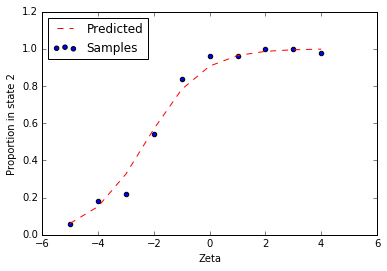

In [7]:
plt.scatter(zetas,fraction)
plt.plot(zetas,predicted, color = 'red', ls = '--')
plt.legend(('Predicted','Samples'),loc = 0)
plt.xlabel('Zeta')
plt.ylabel('Proportion in state 2')
plt.show()